# Decision tree
**Important**: Change the kernel to *PROJECT_NAME local*. You can do this from the *Kernel* menu under *Change kernel*.

In [ ]:
%autosave 0
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RandomizedSearchCV
import pickle
import os
import scipy.stats as st
from itertools import combinations

In [2]:
model_name = "dtree"
aml_dir = os.environ['AZUREML_NATIVE_SHARE_DIRECTORY']
train = pd.read_csv(os.path.join(aml_dir, 'nyc_demand_train.csv'), parse_dates=['timeStamp'])

Using randomised search to find optimal hyperparameters

In [3]:
X = train.drop(['demand', 'timeStamp'], axis=1)

In [4]:
regr = DecisionTreeRegressor()
tscv = TimeSeriesSplit(n_splits=3)

In [28]:
param_dist = {'max_depth': st.randint(2, 20),
              'min_samples_split': st.randint(2, 50),
              'min_samples_leaf': st.randint(1, 100),
              'max_features': range(3,X.shape[1]+1)
             }
regr_cv = RandomizedSearchCV(estimator=regr,
            param_distributions=param_dist,
            n_iter=100,
            cv=tscv,
            iid=False,
            scoring='neg_mean_squared_error',
            verbose=2,
            n_jobs=-1)
regr_pipe = Pipeline([('regr_cv', regr_cv)])
regr_pipe.fit(X, y=train['demand'])

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   17.6s finished


Pipeline(memory=None,
     steps=[('regr_cv', RandomizedSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
          error_score='raise',
          estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_s...it=True,
          return_train_score=True, scoring='neg_mean_squared_error',
          verbose=2))])

In [29]:
with open(os.path.join(aml_dir, model_name + '.pkl'), 'wb') as f:
    pickle.dump(regr_pipe, f)

Cross validation results

In [30]:
cv_results = pd.DataFrame(regr_pipe.named_steps['regr_cv'].cv_results_)
cv_results.sort_values(by='rank_test_score', inplace=True)
cv_results.head()

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
96,0.377332,0.004001,-8632.834509,-5045.032540,17,16,13,13,"{'min_samples_split': 13, 'max_depth': 17, 'mi...",1,-12360.673459,-6691.335810,-7262.428595,-4668.072341,-6275.401474,-3775.689469,0.178300,0.000003,2666.601215,1219.787588
13,0.388361,0.005209,-8856.231710,-5596.776025,18,16,15,2,"{'min_samples_split': 2, 'max_depth': 18, 'min...",2,-12634.192253,-7467.452977,-7191.966060,-5270.033713,-6742.536816,-4052.841386,0.183516,0.007367,2677.714954,1413.025945
81,0.355995,0.002667,-10365.244562,-7550.140027,14,16,22,46,"{'min_samples_split': 46, 'max_depth': 14, 'mi...",3,-14958.658386,-10366.552203,-8547.153504,-6934.972225,-7589.921797,-5348.895654,0.176364,0.001886,3271.458498,2094.125574
39,0.276042,0.010419,-10832.164096,-7399.786640,16,12,19,26,"{'min_samples_split': 26, 'max_depth': 16, 'mi...",4,-15481.578934,-9915.888932,-9192.886377,-6909.418854,-7822.026978,-5374.052134,0.140528,0.007368,3334.927048,1886.339630
55,0.227954,0.003999,-12340.438879,-8331.890015,10,10,1,29,"{'min_samples_split': 29, 'max_depth': 10, 'mi...",5,-16423.777271,-9681.800305,-10374.508853,-8194.815132,-10223.030514,-7119.054609,0.091394,0.003266,2888.018437,1050.716745


Inspect the pairwise distribution of cross validation scores. Darker shades of blue indicate superior performance while the red star represents the optimal solution found.

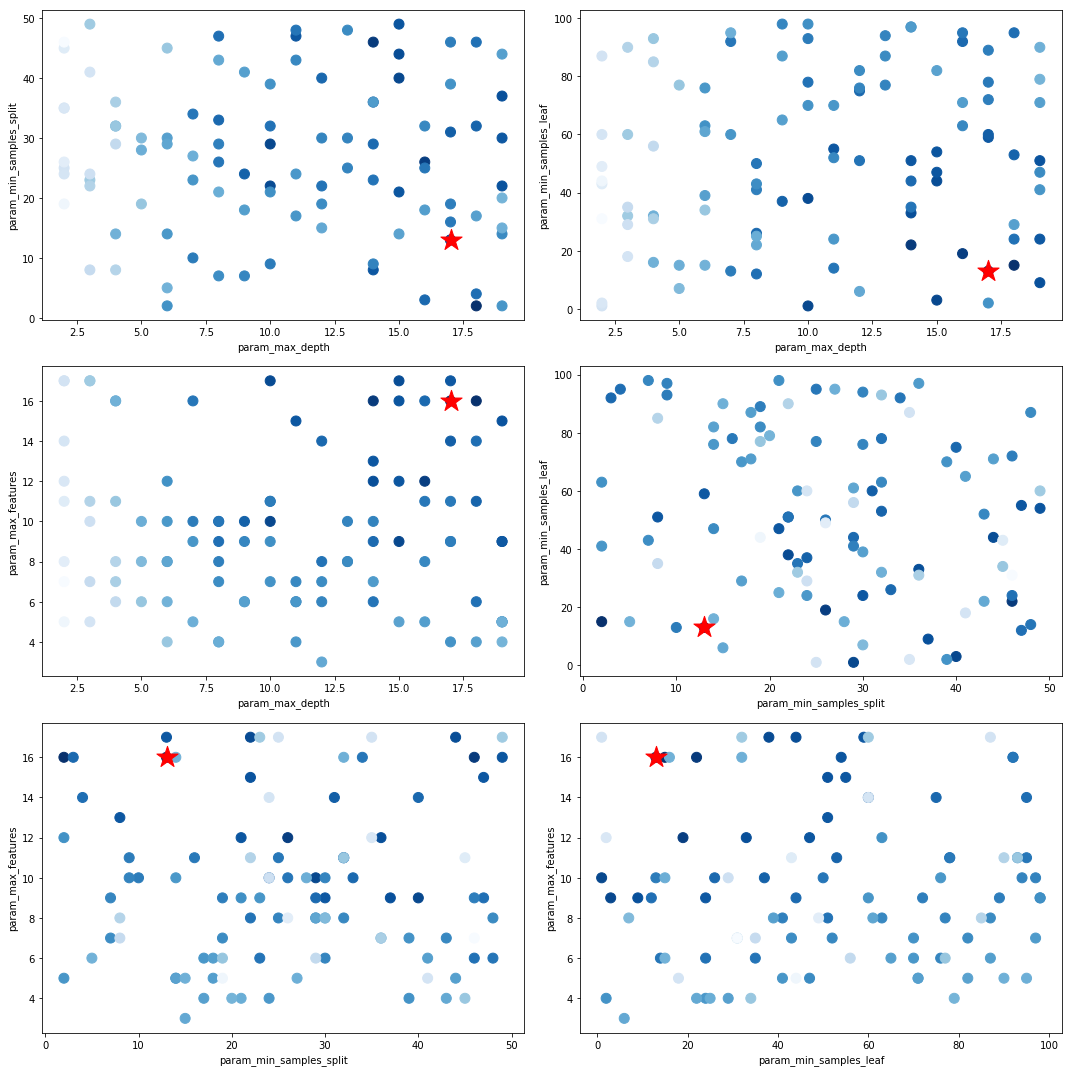

In [33]:
params = ['param_max_depth', 'param_min_samples_split', 'param_min_samples_leaf', 'param_max_features']
gs = gridspec.GridSpec(3,2)
fig = plt.figure(figsize=(15, 15), tight_layout=True)
plt_best = cv_results.head(1)
for idx, params in enumerate(combinations(params, 2)):
    ax = fig.add_subplot(gs[idx])
    plt.scatter(cv_results[params[0]], cv_results[params[1]], c=-np.log(-cv_results['mean_test_score']), s=100, cmap="Blues")
    plt.scatter(plt_best[params[0]], plt_best[params[1]], s=500, marker="*", c="r")
    plt.xlabel(params[0])
    plt.ylabel(params[1])

Inspect feature importance

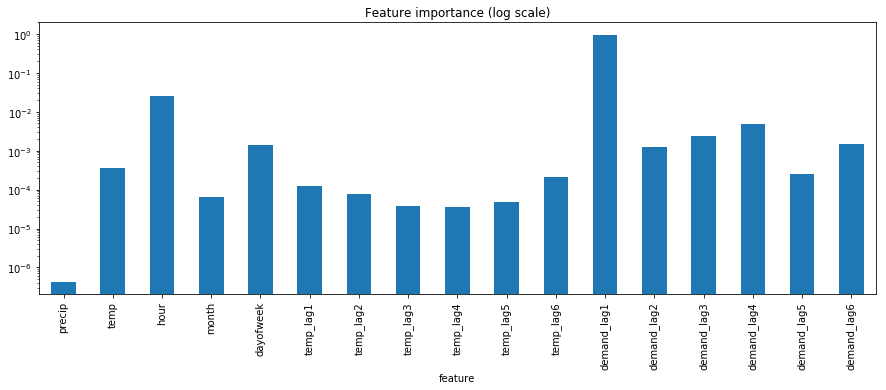

In [34]:
feature_importance = pd.DataFrame.from_dict({'feature':X.columns, 'importance':regr_pipe.named_steps['regr_cv'].best_estimator_.feature_importances_})
feature_importance.plot.bar('feature', 'importance', figsize=(15,5), logy=True, title='Feature importance (log scale)', legend=False)
plt.show()